In [1]:
from DiffEqPy import Variable, DataLoader, test_mode
from DiffEqPy.functions import *
from DiffEqPy.utils import *
from DiffEqPy.layers import *
from DiffEqPy.models import MLP, VGG16, Model
from DiffEqPy.optimizers import SGD
from DiffEqPy.datasets import *
from DiffEqPy.dataloaders import SeqDataLoader
import DiffEqPy
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from PIL import Image



max_epoch = 100
batch_size = 5
hidden_size = 100
bptt_length = 30

train_set = DiffEqPy.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size = batch_size)
seqlen = len(train_set)

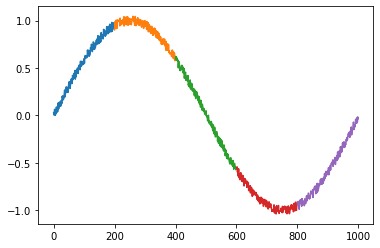

In [2]:
X = []
Y = []
for x,y in dataloader:
    X.append(x.reshape(-1))
    Y.append(y.reshape(-1))
X = np.array(X)
Y = np.array(Y)    
for i in range(batch_size):
    plt.plot(range(len(X)*i, len(X)*(i+1)), X[:,i])

In [3]:
class BetterRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = LSTM(hidden_size)
        self.fc = Linear(out_size)
    
    def reset_state(self):
        self.rnn.reset_state()
    
    def forward(self, x):
        y = self.rnn(x)
        y = self.fc(x)
        return y

In [4]:
model = BetterRNN(hidden_size, 1)
optimizer = SGD(lr=0.001).setup(model)

# Start training.
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in dataloader:
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()

    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.009480
| epoch 2 | loss 0.007077
| epoch 3 | loss 0.005412
| epoch 4 | loss 0.004257
| epoch 5 | loss 0.003456
| epoch 6 | loss 0.002900
| epoch 7 | loss 0.002515
| epoch 8 | loss 0.002248
| epoch 9 | loss 0.002063
| epoch 10 | loss 0.001935
| epoch 11 | loss 0.001846
| epoch 12 | loss 0.001784
| epoch 13 | loss 0.001741
| epoch 14 | loss 0.001711
| epoch 15 | loss 0.001691
| epoch 16 | loss 0.001676
| epoch 17 | loss 0.001667
| epoch 18 | loss 0.001660
| epoch 19 | loss 0.001655
| epoch 20 | loss 0.001652
| epoch 21 | loss 0.001649
| epoch 22 | loss 0.001648
| epoch 23 | loss 0.001647
| epoch 24 | loss 0.001646
| epoch 25 | loss 0.001645
| epoch 26 | loss 0.001645
| epoch 27 | loss 0.001645
| epoch 28 | loss 0.001645
| epoch 29 | loss 0.001644
| epoch 30 | loss 0.001644
| epoch 31 | loss 0.001644
| epoch 32 | loss 0.001644
| epoch 33 | loss 0.001644
| epoch 34 | loss 0.001644
| epoch 35 | loss 0.001644
| epoch 36 | loss 0.001644
| epoch 37 | loss 0.001644
| epoch 38

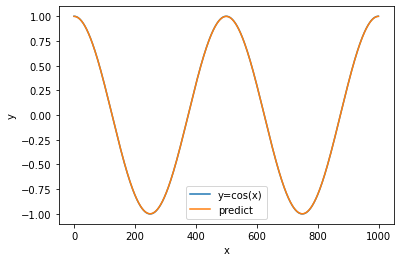

In [5]:
# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with DiffEqPy.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
